In [1]:
# 패키지 임포트

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

sns.set()

In [2]:
# 데이터 로드
# 가격 데이터
with open('./pkl/commodity_price.pkl', 'rb') as f:
    price = pickle.load(f)

# CFTC Hedge 롱포지션
with open('./pkl/long_pos.pkl', 'rb') as f:
    long_pos = pickle.load(f)

# CFTC Hedge 숏포지션
with open('./pkl/short_pos.pkl', 'rb') as f:
    short_pos = pickle.load(f)

# CFTC 전체 포지션
with open('./pkl/total_pos.pkl', 'rb') as f:
    total_pos = pickle.load(f)

In [5]:
# 원자재 밸류 팩터 전략 구현 클래스
class CommodityValue:

    # 초기화 함수
    def __init__(self, price, long_pos, short_pos, total_pos):

        # 가격 데이터
        self.price = price

        # 포지션 데이터
        # CFTC Hedger 롱포지션
        self.long_pos = long_pos

        # CFTC Hegder 숏포지션
        self.short_pos = short_pos

        # CFTC 전체포지션
        self.total_pos = total_pos

        # 롱숏 개수
        self.n = int(len(self.price.columns) / 2)

        # 룩백 윈도우
        self.lookback = 52

        # 투자 가중치
        self.weights = self.calculate_weights(self.long_pos, self.short_pos, self.total_pos, self.lookback)

        # 거래 비용
        self.cost = 0.0005

        # 포트폴리오 자산별 수익률
        self.port_rets = self.calculate_returns(self.price, self.weights, self.cost)

        # 샤프비율
        self.sharpe_ratio = self.calculate_sharpe_ratio(self.port_rets)

        # 포트폴리오 백테스팅 결과 시각화
        self.plot_port_returns(self.port_rets)

    
    # 투자 가중치 계산 함수
    def calculate_weights(self, long_pos, short_pos, total_pos, lookback=52):

        # 롱숏 헷징 레인지
        long_hedging = long_pos / total_pos
        short_hedging = short_pos / total_pos

        long_hedging_range = (long_hedging - long_hedging.rolling(lookback).min()) / (long_hedging.rolling(lookback).max())
        short_hedging_range = (short_hedging - short_hedging.rolling(lookback).min()) / (short_hedging.rolling(lookback).max())

        # 롱숏 랭크
        long_rank = long_hedging_range.rank(axis=1)
        short_rank = short_hedging_range.rank(axis=1)

        # 투자 가중치
        long_weights = (long_rank > self.n) * (1/self.n)
        short_weights = (short_rank > self.n) * -(1/self.n)
        total_weights = long_weights + short_weights

        return total_weights
    
    # 수익률 계산
    def calculate_returns(self, price, weights, cost):

        # 일별 수익률
        rets = price.pct_change()

        # 가중치
        weights = weights.reindex_like(price)
        weights.ffill(inplace=True)

        # 포트폴리오 수익률
        port_rets = (weights.shift() * rets - abs(weights.diff()) * cost)

        return port_rets.sum(axis=1)
    
    # 샤프비율 계산
    def calculate_sharpe_ratio(self, total_returns):
        sharpe_ratio = total_returns.mean() * np.sqrt(252) / total_returns.std()
        return sharpe_ratio
    
    # 백테스팅 결과 시각화
    def plot_port_returns(self, rets):
        plt.figure(figsize=(12, 6))
        rets.cumsum().plot(label='port')
        plt.show()

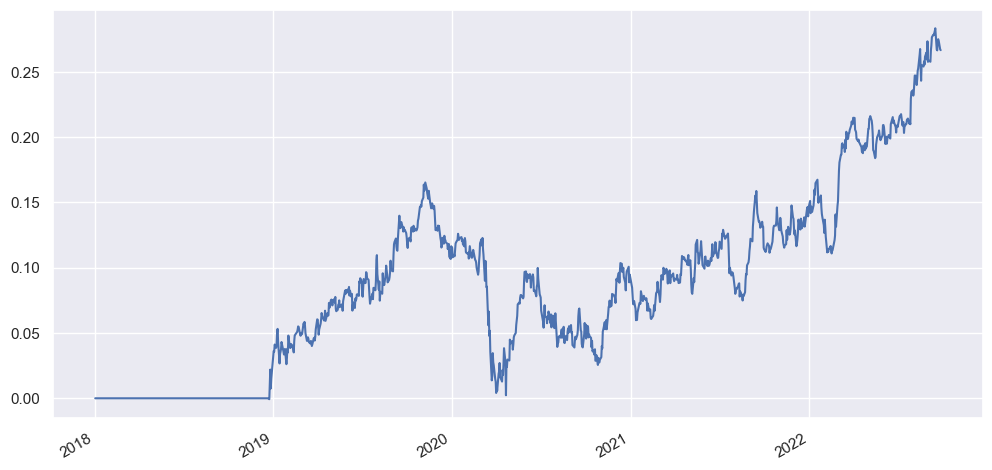

In [6]:
# 백테스팅 실행
value = CommodityValue(price, long_pos, short_pos, total_pos)

In [7]:
value.sharpe_ratio

0.6496877958997476